<a href="https://colab.research.google.com/github/ShawnSchmucker/MAE-494-Fall-2022/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Formulation**

The objective function is the state $s(t) = [x(t), u(t), y(t), v(t), \theta(t), \omega(t)]^T$, where $x(t)$ is the horizontal distance of the rocket from the target landing point, $u(t)$ is its horizontal velocity, $y(t)$ is its vertical distance from the ground, $v(t)$ is its vertical velocity, $\theta(t)$ is its clockwise angle from the vertical, and $\omega(t)$ is its angular velocity.

The control inputs are the rocket's acceleration $a(t)$, and its angular acceleration $\alpha(t)$.

The dynamics are:

$\quad x(t+1) = x(t) + u(t) \Delta t$,

$\quad u(t+1) = u(t) + a(t) \sin(\theta(t)) \Delta t$,

$\quad y(t+1) = y(t) + v(t) \Delta t$,

$\quad v(t+1) = v(t) + a(t) \cos(\theta(t)) \Delta t$,

$\quad \theta(t+1) = \theta(t) + \omega(t) \Delta t$,

$\quad \omega(t+1) = \omega(t) + \alpha(t) \Delta t$,

where $\Delta t$ is the time step.

The controller is $c(t) = [a(t), \alpha(t)]^T = f_\theta(s(t))$, where $f_\theta$ is a neural network with optimized parameters $\theta$.

The loss is 0 for all time $t = 1,...,T-1$, where $T$ is the final time step. At $t = T,$ the loss $l(s(T), c(T)) = ||s(T)||^2 = x(T)^2 + u(T)^2 + y(T)^2 + v(T)^2 + \theta(T)^2 + \omega(T)^2$.

The optimization problem is:

$\quad \min \limits_{\theta} \quad ||s(T)||^2$

$\qquad \qquad x(t+1) = x(t) + u(t) \Delta t$,

$\qquad \qquad u(t+1) = u(t) + a(t) \sin(\theta(t)) \Delta t$,

$\qquad \qquad y(t+1) = y(t) + v(t) \Delta t$,

$\qquad \qquad v(t+1) = v(t) + a(t) \cos(\theta(t)) \Delta t$,

$\qquad \qquad \theta(t+1) = \theta(t) + \omega(t) \Delta t$,

$\qquad \qquad \omega(t+1) = \omega(t) + \alpha(t) \Delta t$,

$\qquad \qquad c(t) = [a(t), \alpha(t)]^T = f_\theta(s(t)), \, \forall t = 1,...,T-1$.

This formulation assumes...

[1] loss: 0.995


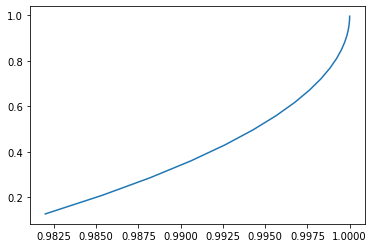

[2] loss: 0.975


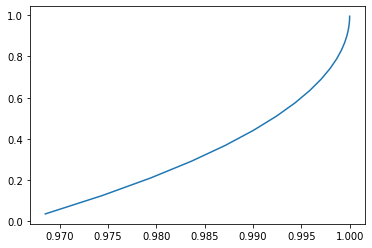

[3] loss: 0.830


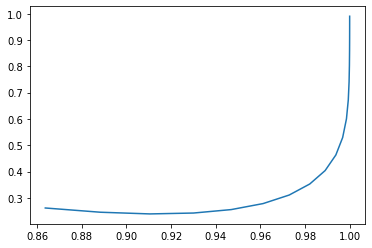

[4] loss: 0.705


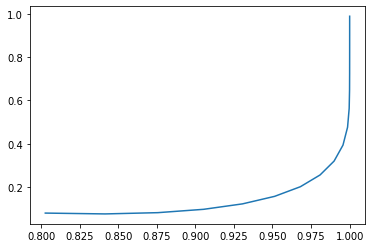

[5] loss: 0.691


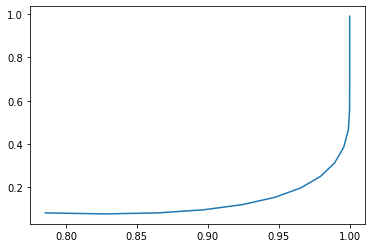

[6] loss: 0.688


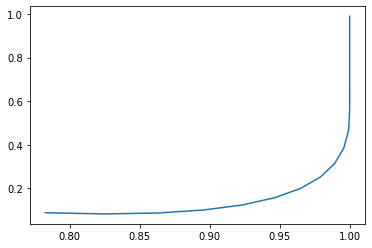

[7] loss: 0.688


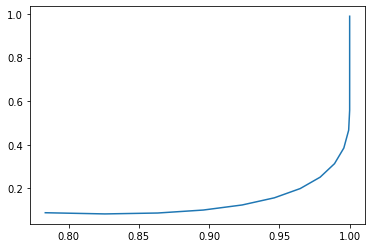

[8] loss: 0.688


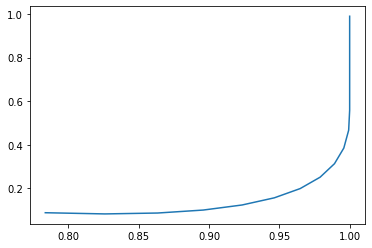

[9] loss: 0.688


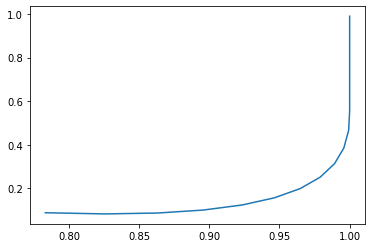

[10] loss: 0.688


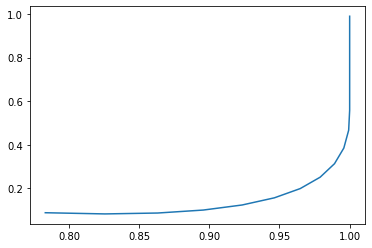

[11] loss: 0.688


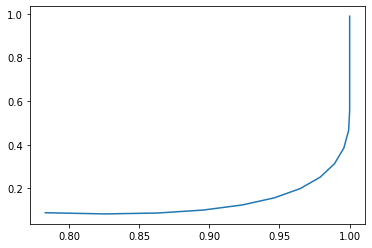

[12] loss: 0.688


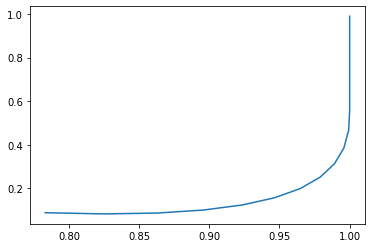

[13] loss: 0.688


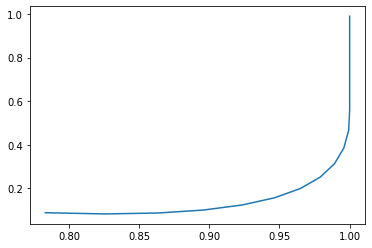

[14] loss: 0.688


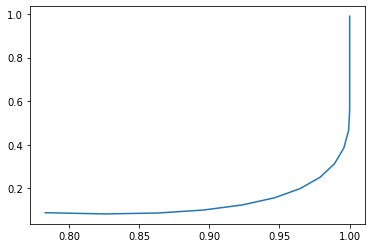

[15] loss: 0.688


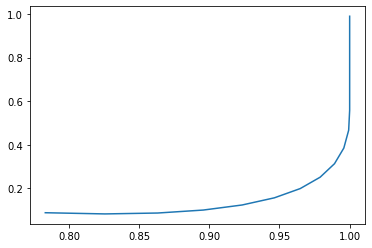

[16] loss: 0.688


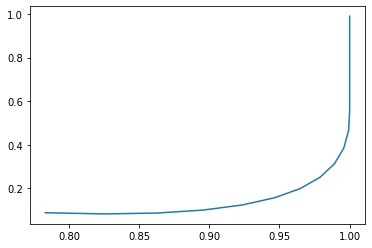

[17] loss: 0.688


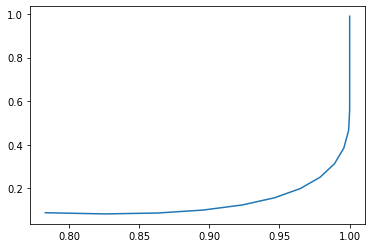

[18] loss: 0.688


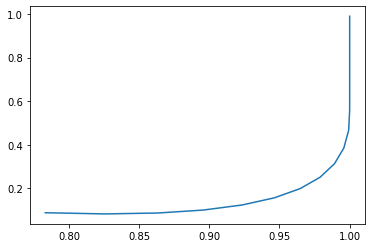

[19] loss: 0.688


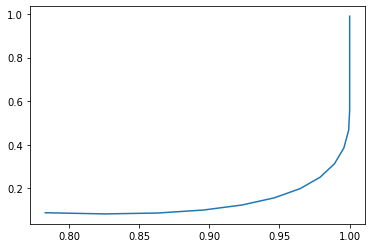

[20] loss: 0.688


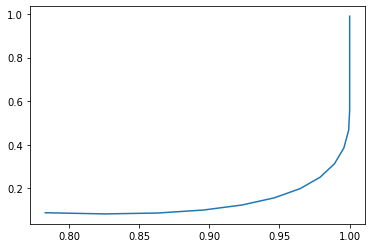

[21] loss: 0.688


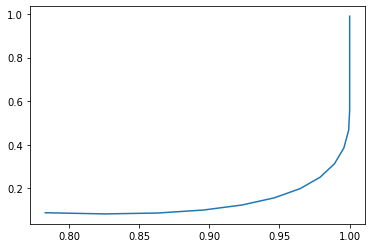

[22] loss: 0.688


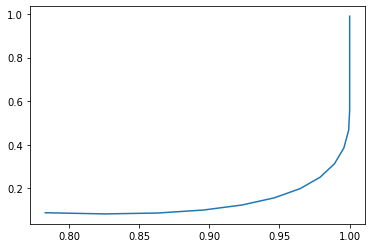

[23] loss: 0.688


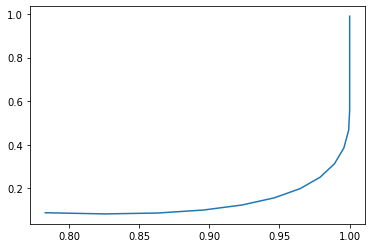

[24] loss: 0.688


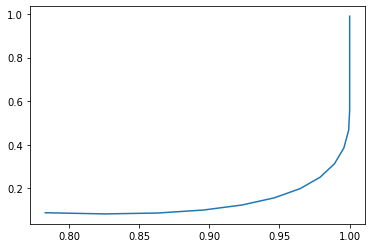

[25] loss: 0.688


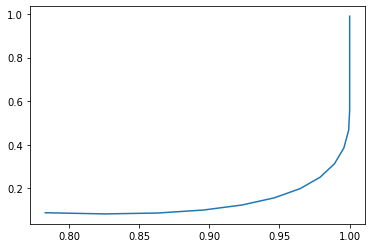

[26] loss: 0.688


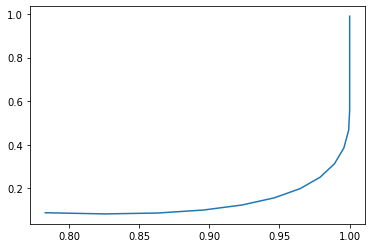

[27] loss: 0.688


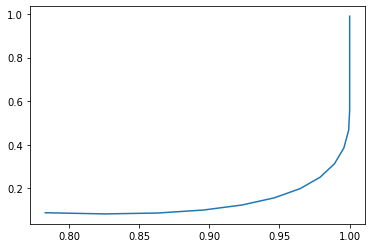

[28] loss: 0.688


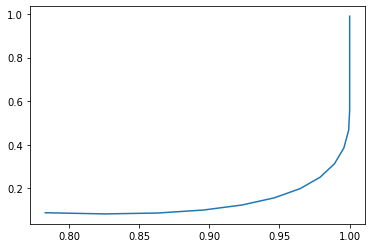

[29] loss: 0.688


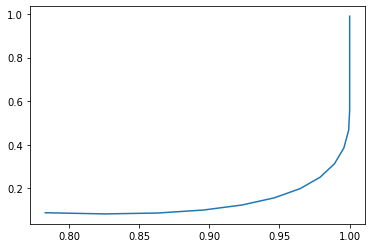

[30] loss: 0.688


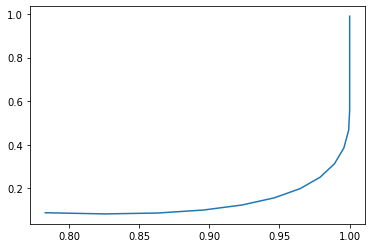

[31] loss: 0.688


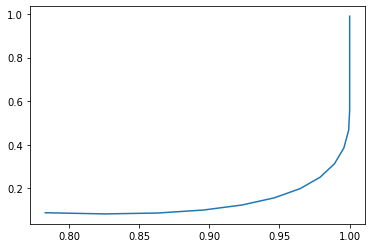

[32] loss: 0.688


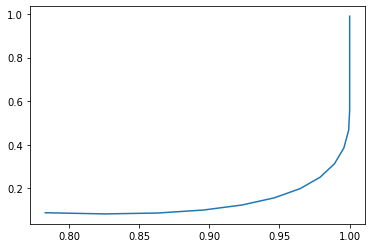

[33] loss: 0.688


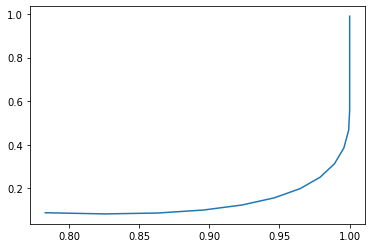

[34] loss: 0.688


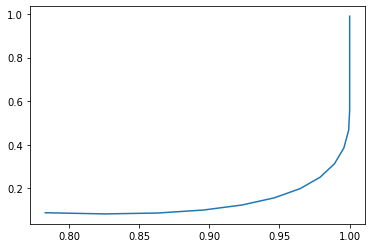

[35] loss: 0.688


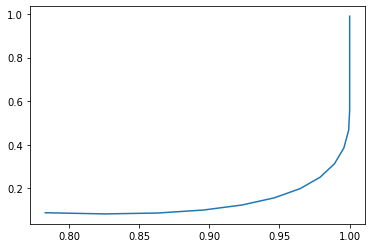

[36] loss: 0.688


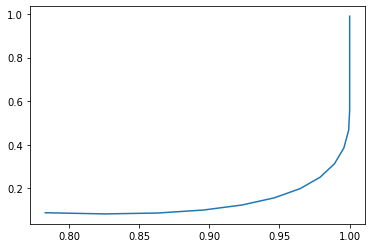

[37] loss: 0.688


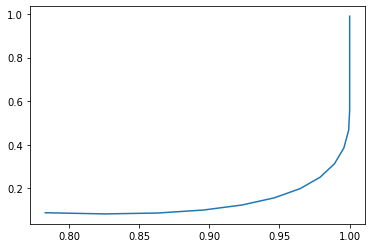

[38] loss: 0.688


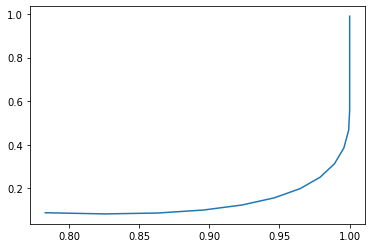

[39] loss: 0.688


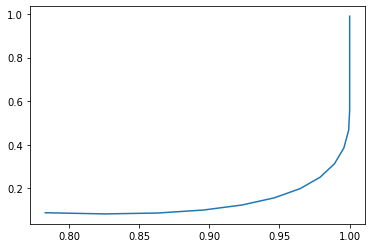

[40] loss: 0.688


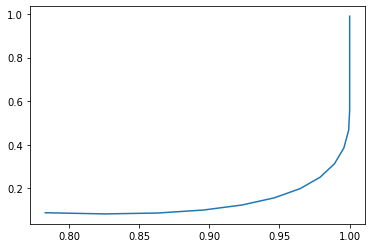

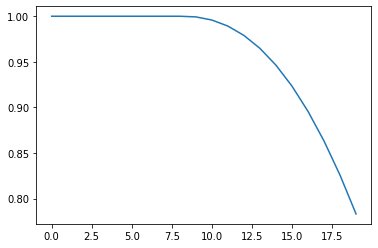

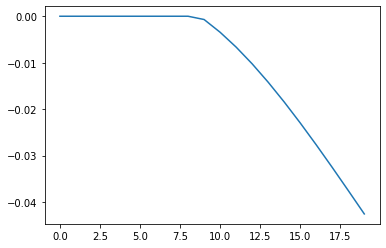

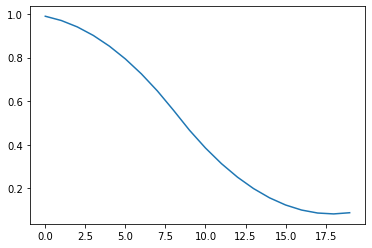

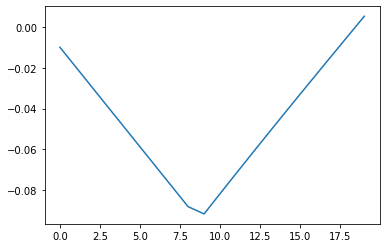

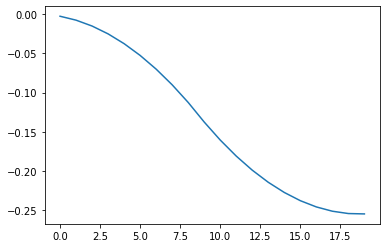

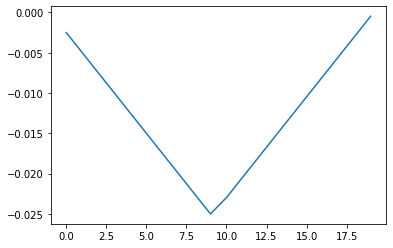

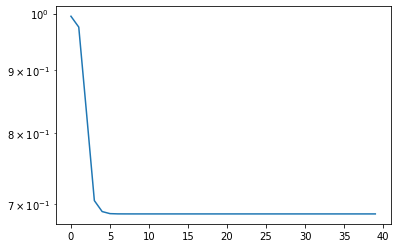

In [74]:
import numpy as np
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

t.manual_seed(0)

DT = 1 # time step
G = 9.81 / 1000 # gravitational acceleration constant
THRUST = 20 / 1000 # linear thrust constant
ROTATE = 5 / 1000 # rotational thrust constant

class Dynamics(nn.Module):

  def __init__(self):
    super(Dynamics, self).__init__()
  
  @staticmethod
  def forward(state, action):
    """
    action[0] = thrust controller
    action[1] = rotation controller
    
    state[0] = x
    state[1] = x_dot
    state[2] = y
    state[3] = y_dot
    state[4] = theta
    state[5] = theta_dot
    """

    dx_gravity = t.tensor([0., 0., 0., -G * DT, 0., 0.])

    state_tensor = t.zeros((6, 2))
    state_tensor[1, 0] = THRUST * DT * t.sin(state[4])
    state_tensor[3, 0] = THRUST * DT * t.cos(state[4])
    state_tensor[5, 1] = ROTATE * DT
    dx_thrust = t.matmul(action, t.t(state_tensor))

    state = state + dx_gravity + dx_thrust
    
    step_mat = t.tensor([[1., DT, 0., 0., 0., 0.],
                         [0., 1., 0., 0., 0., 0.],
                         [0., 0., 1., DT, 0., 0.],
                         [0., 0., 0., 1., 0., 0.],
                         [0., 0., 0., 0., 1., DT],
                         [0., 0., 0., 0., 0., 1.]])
    
    state = t.matmul(step_mat, state)

    return state

class Controller(nn.Module):

  def __init__(self, dim_input, dim_hidden, dim_output):

    super(Controller, self).__init__()
    self.network = nn.Sequential(
        nn.Linear(dim_input, dim_hidden),
        nn.Tanh(),
        nn.Linear(dim_hidden, dim_output),
        nn.Sigmoid()
    )
  
  def forward(self, state):
    action = self.network(state)
    return action

class Simulation(nn.Module):

  def __init__(self, controller, dynamics, T):
    super(Simulation, self).__init__()
    self.state = self.initialize_state()
    self.controller = controller
    self.dynamics = dynamics
    self.T = T
    self.action_trajectory = []
    self.state_trajectory = []
  
  def forward(self, state):
    self.action_trajectory = []
    self.state_trajectory = []
    for _ in range(T):
      action = self.controller.forward(state)
      action_tensor = t.tensor([0., -0.5])
      action = action + action_tensor
      state = self.dynamics.forward(state, action)
      self.action_trajectory.append(action)
      self.state_trajectory.append(state)
    return self.error(state)
  
  @staticmethod
  def initialize_state():
    state = [1., 0., 1., 0., 0., 0.]
    return t.tensor(state, requires_grad=False).float()
  
  def error(self, state):
    return 1 * state[0]**2 + 1 * state[1]**2 + 1 * state[2]**2 + 1 * state[3]**2 + 1 * state[4]**2 + 1 * state[5]**2

class Optimize:
  data_final = np.array([])
  losses = np.array([])
  
  def __init__(self, simulation):
    self.simulation = simulation
    self.parameters = simulation.controller.parameters()
    self.optimizer = optim.LBFGS(self.parameters, lr=0.1)
  
  def step(self):
    def closure():
      loss = self.simulation(self.simulation.state)
      self.optimizer.zero_grad()
      loss.backward()
      return loss
    self.optimizer.step(closure)
    return closure()
  
  def train(self, epochs):
    for epoch in range(epochs):
      loss = self.step()
      with t.no_grad():
        self.losses = np.append(self.losses, loss.detach().numpy())
      print('[%d] loss: %.3f' % (epoch + 1, loss))
      self.visualize()
  
  def visualize(self):
    data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
    x = data[:, 0]
    y = data[:, 2]
    plt.plot(x, y)
    plt.show()
    self.data_final = data

T = 20
dim_input = 6
dim_hidden = 6
dim_output = 2
d = Dynamics()
c = Controller(dim_input, dim_hidden, dim_output)
s = Simulation(c, d, T)
o = Optimize(s)
train = 40
o.train(train)

data_final = o.data_final
x = data_final[:, 0]
u = data_final[:, 1]
y = data_final[:, 2]
v = data_final[:, 3]
theta = data_final[:, 4]
omega = data_final[:, 5]
t = [i for i in range(T)]

plt.figure()
plt.plot(t, x)
plt.figure()
plt.plot(t, u)
plt.figure()
plt.plot(t, y)
plt.figure()
plt.plot(t, v)
plt.figure()
plt.plot(t, theta)
plt.figure()
plt.plot(t, omega)

steps = [i for i in range(train)]
losses = o.losses
plt.figure()
plt.yscale('log')
plt.plot(steps, losses)